In [5]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models,optimizers,losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import os

# resnet50
from keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [6]:
train_dir ='datafood/Fast Food Classification V2/Train'
test_dir = 'datafood/Fast Food Classification V2/Valid'

In [7]:
# Augment train set only
train_data_generator = ImageDataGenerator(
                    validation_split=0.15,
                    rotation_range=15,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    preprocessing_function=preprocess_input,
                    shear_range=0.1,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='nearest')

val_data_generator = ImageDataGenerator(
                    preprocessing_function=preprocess_input,
                    validation_split=0.15)

In [8]:
HYP = dict(
    seed = 77,
    batch_size = 32,
    img_size = (256,256),
    epochs = 20,
    patience = 5)

In [9]:
train_generator = train_data_generator.flow_from_directory(
                train_dir, target_size=HYP['img_size'],
                shuffle=True, seed=HYP['seed'],
                class_mode='categorical', 
                batch_size=HYP['batch_size'],
                subset="training")

validation_generator = val_data_generator.flow_from_directory(
                    train_dir, target_size=HYP['img_size'],
                    shuffle=False, seed=HYP['seed'],
                    class_mode='categorical',
                    batch_size=HYP['batch_size'],
                    subset="validation")

Found 12750 images belonging to 10 classes.
Found 2250 images belonging to 10 classes.


In [10]:
# LearningRateScheduler
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.001 * tf.math.exp(0.001 * (5 - epoch))
    
lr_scheduler = LearningRateScheduler(scheduler)

# early_stopping    
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=True)

callbacks = [early_stopping, lr_scheduler]

In [11]:
# Resnet50
model_res50 = Sequential()

model_res50.add(ResNet50(
include_top=False,
pooling='avg',
weights='imagenet'
))

model_res50.add(Dense(1024, activation='relu'))

model_res50.add(Dropout(0.5))

model_res50.add(Dense(10, activation='softmax'))

model_res50.layers[0].trainable = False

model_res50.summary()

steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)

model_res50.compile(optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                10250     
                                                                 
Total params: 25,696,138
Trainable params: 2,108,426
Non-trainable params: 23,587,712
_________________________________________________________________


In [12]:
it_history = model_res50.fit(
            train_generator,
            steps_per_epoch=steps_per_epoch_training,
            validation_steps=steps_per_epoch_validation,
            epochs=HYP['epochs'],
            validation_data=validation_generator,
            verbose=1,
            callbacks=callbacks
            )

Epoch 1/20
117/399 [=======>......................] - ETA: 7:53 - loss: 1.3185 - accuracy: 0.6092

c:\Users\devia.e13\Anaconda3\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


399/399 [==============================] - 784s 2s/step - loss: 0.9512 - accuracy: 0.7067 - val_loss: 0.6048 - val_accuracy: 0.8093 - lr: 0.0010
Epoch 2/20
399/399 [==============================] - 779s 2s/step - loss: 0.6800 - accuracy: 0.7828 - val_loss: 0.5416 - val_accuracy: 0.8262 - lr: 0.0010
Epoch 3/20
399/399 [==============================] - 814s 2s/step - loss: 0.6166 - accuracy: 0.8015 - val_loss: 0.4996 - val_accuracy: 0.8387 - lr: 0.0010
Epoch 4/20
399/399 [==============================] - 811s 2s/step - loss: 0.5766 - accuracy: 0.8182 - val_loss: 0.4983 - val_accuracy: 0.8471 - lr: 0.0010
Epoch 5/20
399/399 [==============================] - 797s 2s/step - loss: 0.5455 - accuracy: 0.8270 - val_loss: 0.4884 - val_accuracy: 0.8476 - lr: 0.0010
Epoch 6/20
399/399 [==============================] - 800s 2s/step - loss: 0.5197 - accuracy: 0.8337 - val_loss: 0.4580 - val_accuracy: 0.8484 - lr: 0.0010
Epoch 7/20
399/399 [==============================] - 783s 2s/step - loss: 

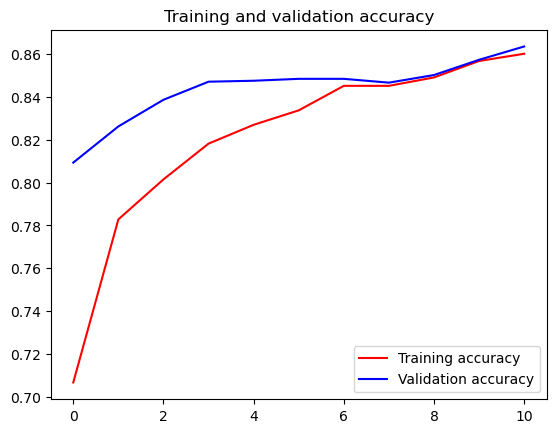

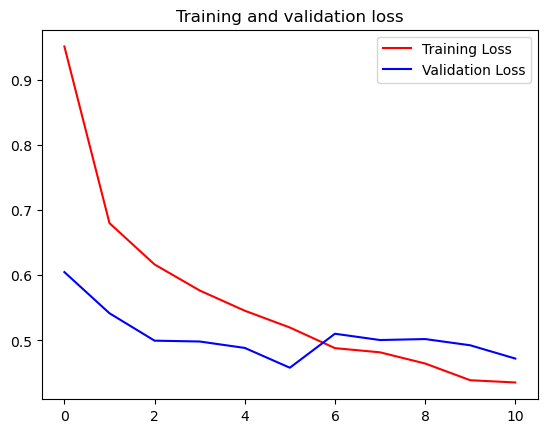

In [13]:
acc = it_history.history['accuracy']
val_acc = it_history.history['val_accuracy']
loss = it_history.history['loss']
val_loss = it_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')

plt.legend()

plt.show()

71/71 [==============================] - 129s 2s/step


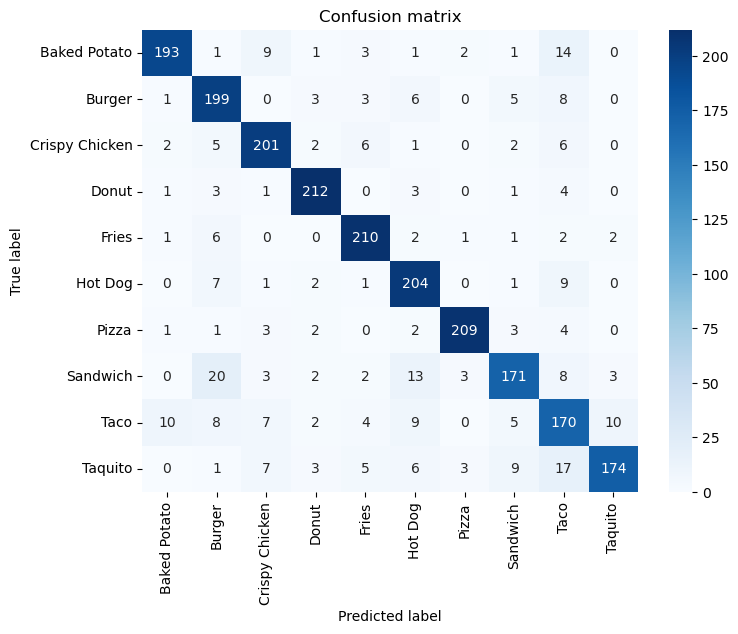

In [194]:
# Confusion matrix

classes = train_generator.class_indices.keys()

y_pred = np.argmax(model_res50.predict(validation_generator), axis=1)
cm = confusion_matrix(validation_generator.classes, y_pred)

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cbar=True, cmap='Blues',xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

In [15]:
score = model_res50.evaluate(validation_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.47209587693214417
Test accuracy: 0.8635555505752563


In [16]:
# https://www.kaggle.com/code/takanao/firstfood-resnet50-simple

In [ ]:
model_res50.predict()

# Test

In [17]:
# x = tf.data
# pred = model_res50.predict(x)
import cv2

1/1 [==============================] - 0s 105ms/step


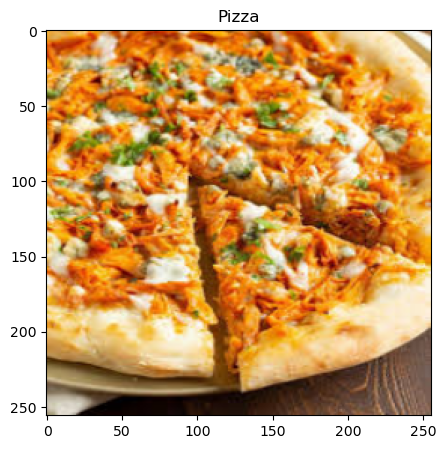

In [179]:
img = cv2.imread('test.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resize = tf.image.resize(img, (256,256))
prediction = model_res50.predict(np.expand_dims(resize/255, 0))
label = prediction.argmax()
list_class = list(classes)

plt.figure(figsize=(5,5))
plt.title(list_class[label - 1 ])
plt.imshow(resize.numpy().astype(int))
plt.show()

In [153]:
# img_batch = ("test/Pizza")

# def load_images_from_folder(img_batch):
#     images = []
#     for filename in os.listdir(img_batch):
#         img = cv2.imread(os.path.join(img_batch,filename))
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         if img is not None:
#             images.append(img)
#     return images


# images = load_images_from_folder(img_batch)



1/1 [==============================] - 0s 97ms/step


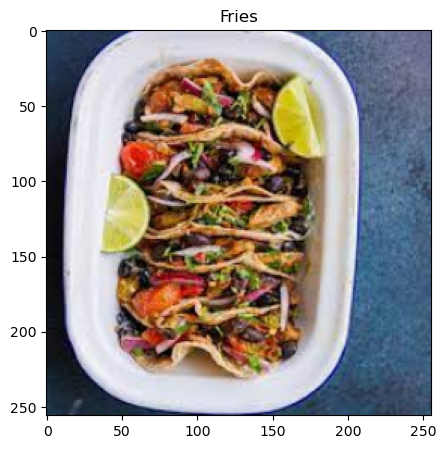

In [207]:
test = cv2.imread('datafood/Fast Food Classification V2/Test/Taco/Taco-test (60).jpeg')
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
resize = tf.image.resize(test, (256,256))
prediction = model_res50.predict(np.expand_dims(resize/255, 0))
label = prediction.argmax()
list_class = list(classes)

plt.figure(figsize=(5,5))
plt.title(list_class[label - 1 ])
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
list_class

# Save Model

In [155]:
from tensorflow.keras.models import load_model

In [156]:
# model_res50.save(os.path.join('models','Res50.h5'))
# new_model = load_model('models/Res50.h5')

1/1 [==============================] - 0s 129ms/step


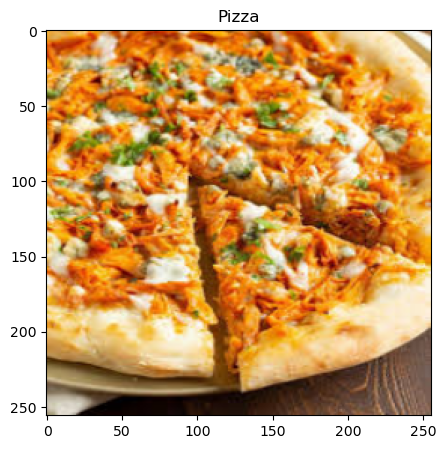

In [158]:
img = cv2.imread('test.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resize = tf.image.resize(img, (256,256))
prediction = new_model.predict(np.expand_dims(resize/255, 0))
label = prediction.argmax()
list_class = list(classes)

plt.figure(figsize=(5, 5))
plt.title(list_class[label - 1 ])
plt.imshow(resize.numpy().astype(int))
plt.show()